# Device Class

Defines the `Device` class representing a client in federated learning. Each device has:
- Hardware attributes (RAM, storage, CPU, etc.).
- A local CNN model for MNIST.
- Training and test data partitions.

In [30]:
class Device:
    """
    A class representing a device in a federated learning system.

    Attributes:
        device_id (int): Unique identifier for the device.
        ram, storage, cpu, bandwidth, battery, charging (float): Hardware attributes.
        energy_consumption (float): Sum of hardware attributes (proxy for energy use).
        model (keras.Model): Local CNN model for MNIST classification.
        last_round_participated (int): Last training round the device participated in.
        data (tuple): Training data (x_train, y_train).
        test_data (tuple): Test data (x_test, y_test).
        number_of_times_fitted (int): Number of times the model has been trained.
    """

    def __init__(self, device_id, ram, storage, cpu, bandwidth, battery, charging, train_data=None, test_data=None):
        """Initialize a device with hardware attributes and optional data."""
        self.device_id = device_id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.energy_consumption = (6.0 - (ram + storage + cpu + bandwidth + charging + battery))/6.0
        self.model = self.create_model()
        self.last_round_participated = 0
        self.data = train_data
        self.test_data = test_data
        self.number_of_times_fitted = 0

        # Validate test_data if provided
        if test_data is not None:
            x_test, y_test = test_data
            if x_test.shape[0] == 0 or y_test.shape[0] == 0:
                raise ValueError(f"Device {device_id} initialized with empty test_data: "
                                 f"x_shape={x_test.shape}, y_shape={y_test.shape}")
            if np.mean(x_test) < 0.01:
                raise ValueError(f"Device {device_id} x_test is zeroed-out: mean={np.mean(x_test):.4f}")

    def create_model(self):
        """Create a CNN model for MNIST classification."""
        model = keras.Sequential([
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, epochs=1, batch_size=32):
        """Train the local model on the device's training data."""
        if self.data is None:
            raise ValueError(f"Device {self.device_id} has no training data")
        x_train, y_train = self.data

        print(self.device_id)

        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0) # verbose could be 1
        self.number_of_times_fitted += 1
        self.last_round_participated += 1

print("Device class defined.")

Device class defined.


# Global Model and Aggregation

Defines the global CNN model and the function to aggregate device weights for federated learning.

In [31]:
def create_global_model():
    """
    Create a global CNN model for MNIST classification.

    Returns:
        keras.Model: Compiled Keras model.
    """
    model = keras.Sequential([
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def aggregate_weights(devices):
    """
    Aggregate weights from devices using federated averaging, weighted by training data size.

    Args:
        devices (list): List of Device objects.

    Returns:
        list: Aggregated model weights.
    """
    total_samples = sum(len(device.data[0]) for device in devices if device.data is not None)
    if total_samples == 0:
        raise ValueError("No training data available for aggregation")

    # Initialize with zeros based on the first device's weights
    aggregated_weights = [np.zeros_like(w) for w in devices[0].model.get_weights()]

    # Sum weighted weights
    for device in devices:
        if device.data is None:
            continue
        num_samples = len(device.data[0])
        weight_factor = num_samples / total_samples
        for i, w in enumerate(device.model.get_weights()):
            aggregated_weights[i] += w * weight_factor

    return aggregated_weights

print("Global model and aggregation functions defined.")

Global model and aggregation functions defined.


# Data Loading and Distribution

Loads the MNIST dataset, preprocesses it, and distributes:
- Training data: Evenly across devices.
- Test data: 20% to global model, 80% to devices.
Validates data to prevent zeroed-out or empty arrays.

In [32]:
import keras
import numpy as np
from keras import layers

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Validate loaded data
print(f"Loaded MNIST: x_train_shape={x_train.shape}, y_train_shape={y_train.shape}, "
      f"x_test_shape={x_test.shape}, y_test_shape={y_test.shape}")
if x_test.shape[0] == 0 or y_test.shape[0] == 0:
    raise ValueError("MNIST test data is empty")

# Preprocess: Normalize, reshape, and one-hot encode
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Verify preprocessing
print(f"Preprocessed: x_test_shape={x_test.shape}, y_test_shape={y_test.shape}, x_test_mean={np.mean(x_test):.4f}")
if np.mean(x_test) < 0.01:
    raise ValueError("x_test appears zeroed-out after preprocessing")

# Parameters
NUM_DEVICES = 30
NUM_GENERATIONS = 4  # Adjust as needed, was 10 at first

# Split test data: 20% global, 80% devices
total_test_samples = len(x_test)  # 10,000
global_test_samples = int(0.2 * total_test_samples)  # 2,000
device_test_samples = total_test_samples - global_test_samples  # 8,000
test_samples_per_device = device_test_samples // NUM_DEVICES  # ~266
remainder = device_test_samples % NUM_DEVICES  # 20

# Assign global test data
x_test_global = x_test[:global_test_samples]
y_test_global = y_test[:global_test_samples]
print(f"Global test data: x_shape={x_test_global.shape}, y_shape={y_test_global.shape}, x_mean={np.mean(x_test_global):.4f}")
if x_test_global.shape != (2000, 28, 28, 1) or y_test_global.shape != (2000, 10):
    raise ValueError("Incorrect global test data shapes")

# Create devices and distribute data
train_samples_per_device = len(x_train) // NUM_DEVICES  # ~2,000
devices = []
test_idx = global_test_samples
for i in range(NUM_DEVICES):
    # Training data
    start_idx = i * train_samples_per_device
    end_idx = (i + 1) * train_samples_per_device
    train_data = (x_train[start_idx:end_idx], y_train[start_idx:end_idx])

    # Test data
    num_samples = test_samples_per_device + (1 if i < remainder else 0)
    if test_idx + num_samples > total_test_samples:
        raise ValueError(f"Test index overflow for device {i}: test_idx={test_idx}, num_samples={num_samples}")
    test_data = (
        x_test[test_idx:test_idx + num_samples],
        y_test[test_idx:test_idx + num_samples]
    )
    test_idx += num_samples

    # Validate test data
    x_device_test, y_device_test = test_data
    if x_device_test.shape[0] == 0 or y_device_test.shape[0] == 0:
        raise ValueError(f"Device {i} test data is empty: x_shape={x_device_test.shape}, y_shape={y_device_test.shape}")
    if x_device_test.shape[1:] != (28, 28, 1) or y_device_test.shape[1:] != (10,):
        raise ValueError(f"Device {i} test data has incorrect shapes: x_shape={x_device_test.shape}, y_shape={y_device_test.shape}")
    x_mean = np.mean(x_device_test)
    if x_mean < 0.01:
        raise ValueError(f"Device {i} x_test appears zeroed-out: mean={x_mean:.4f}")

    # Create device
    device = Device(
        device_id=i,
        ram=np.random.uniform(0.0, 1.0),
        storage=np.random.uniform(0.0, 1.0),
        cpu=np.random.uniform(0.0, 1.0),
        bandwidth=np.random.uniform(0.0, 1.0),
        battery=np.random.uniform(0.0, 1.0),
        # charging=np.random.uniform(0.5, 1.0),
        charging = np.random.choice([0.0, 1.0]),
        train_data=train_data,
        test_data=test_data
    )
    devices.append(device)

    print(device.energy_consumption)

    # Log device data
    x_train_d, y_train_d = device.data
    x_test_d, y_test_d = device.test_data
    print(f"Device {i}: train_x_shape={x_train_d.shape}, train_y_shape={y_train_d.shape}, "
          f"test_x_shape={x_test_d.shape}, test_y_shape={y_test_d.shape}, test_x_mean={np.mean(x_test_d):.4f}")

# Verify total test samples
total_device_samples = sum(device.test_data[0].shape[0] for device in devices)
print(f"Total device test samples: {total_device_samples}, Expected: {device_test_samples}")
if total_device_samples != device_test_samples:
    raise ValueError("Mismatch in total device test samples")

print("Data distributed successfully.")

Loaded MNIST: x_train_shape=(60000, 28, 28), y_train_shape=(60000,), x_test_shape=(10000, 28, 28), y_test_shape=(10000,)
Preprocessed: x_test_shape=(10000, 28, 28, 1), y_test_shape=(10000, 10), x_test_mean=0.1325
Global test data: x_shape=(2000, 28, 28, 1), y_shape=(2000, 10), x_mean=0.1209
2.682576778099271
Device 0: train_x_shape=(2000, 28, 28, 1), train_y_shape=(2000, 10), test_x_shape=(267, 28, 28, 1), test_y_shape=(267, 10), test_x_mean=0.1238
3.243281635144892
Device 1: train_x_shape=(2000, 28, 28, 1), train_y_shape=(2000, 10), test_x_shape=(267, 28, 28, 1), test_y_shape=(267, 10), test_x_mean=0.1208
2.588548569646492
Device 2: train_x_shape=(2000, 28, 28, 1), train_y_shape=(2000, 10), test_x_shape=(267, 28, 28, 1), test_y_shape=(267, 10), test_x_mean=0.1220
3.0826101292338404
Device 3: train_x_shape=(2000, 28, 28, 1), train_y_shape=(2000, 10), test_x_shape=(267, 28, 28, 1), test_y_shape=(267, 10), test_x_mean=0.1226
2.6674055968975217
Device 4: train_x_shape=(2000, 28, 28, 1), t

# Federated Learning Setup and Optimization

Defines the federated learning problem, trains devices, aggregates weights, and runs multi-objective optimization.

In [33]:
!pip install pymoo

In [35]:
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination


class FederatedLearningProblem(Problem):
    """
    A pymoo Problem for federated learning optimization.

    Objectives:
    - Minimize negative accuracy (maximize accuracy) on device test data.
    - Minimize energy consumption based on device participation.

    Variables:
    - Binary vector indicating which devices participate in each round (0 or 1).
    """

    def __init__(self, devices, global_model, x_test_global, y_test_global):
        """Initialize the problem with devices and global test data."""
        self.devices = devices
        self.global_model = global_model
        self.x_test_global = x_test_global
        self.y_test_global = y_test_global
        super().__init__(n_var=len(devices), n_obj=2, n_constr=0, xl=0, xu=1, vtype=bool)

    def _evaluate(self, x, out, *args, **kwargs):
        """Evaluate the objectives for each solution."""
        f1 = []  # Negative accuracy
        f2 = []  # Energy consumption

        for solution in x:
            # Validate binary solution
            if not np.all(np.logical_or(solution == 0, solution == 1)):
                raise ValueError(f"Non-binary solution detected: {solution}")

            # Debug: Log solution vector
            num_selected = np.sum(solution)
            print(f"Solution vector: {solution}, Selected devices: {num_selected}")
            if num_selected == 0:
                print("Warning: No devices selected for this solution")

            # Select participating devices
            selected_devices = [self.devices[i] for i, participate in enumerate(solution) if participate]

            if not selected_devices:
                f1.append(0.0)  # No devices selected, worst accuracy
                f2.append(0.0)  # No energy consumption
                continue

            # Train selected devices
            for device in selected_devices:
                device.train(epochs=1, batch_size=32)

            # Aggregate weights
            new_weights = aggregate_weights(selected_devices)
            self.global_model.set_weights(new_weights)

            # Evaluate accuracy on global test data
            _, accuracy = self.global_model.evaluate(self.x_test_global, self.y_test_global, verbose=0)
            f1.append(-accuracy)  # Minimize negative accuracy

            # Compute energy consumption
            energy = sum(device.energy_consumption for device in selected_devices)
            f2.append(energy)

            # Evaluate fairness (accuracy variance across devices)
            device_accuracies = []
            for device in self.devices:
                x_test, y_test = device.test_data
                if x_test.shape[0] == 0:
                    continue
                _, acc = self.global_model.evaluate(x_test, y_test, verbose=0)
                device_accuracies.append(acc)
            fairness = np.var(device_accuracies) if device_accuracies else 0.0
            print(f"Solution: Accuracy={-f1[-1]:.4f}, Energy={f2[-1]:.4f}, Fairness_variance={fairness:.4f}")

        out["F"] = np.column_stack([f1, f2])

# Initialize global model
global_model = create_global_model()

# Audit test data before optimization
print("--- Auditing test data before optimization ---")
for device in devices:
    x_test, y_test = device.test_data
    x_mean = np.mean(x_test) if x_test.size > 0 else 0.0
    print(f"Device {device.device_id}: x_shape={x_test.shape}, y_shape={y_test.shape}, x_mean={x_mean:.4f}")
    if x_test.shape[0] == 0 or y_test.shape[0] == 0:
        raise ValueError(f"Device {device.device_id} has empty test data")
    if x_mean < 0.01:
        raise ValueError(f"Device {device.device_id} x_test is zeroed-out: mean={x_mean:.4f}")

# Set up optimization with binary operators
algorithm = NSGA2(
    pop_size=3,
    sampling=BinaryRandomSampling(),
    crossover=UniformCrossover(prob=0.9),
    mutation=BitflipMutation(prob=1.0 / len(devices)),
    eliminate_duplicates=True
)

# Run optimization
res = minimize(
    problem=FederatedLearningProblem(devices, global_model, x_test_global, y_test_global),
    algorithm=algorithm,
    termination=DefaultMultiObjectiveTermination(n_max_gen=NUM_GENERATIONS),
    seed=42,
    verbose=True
)

print("Optimization completed.")

--- Auditing test data before optimization ---
Device 0: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1238
Device 1: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1208
Device 2: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1220
Device 3: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1226
Device 4: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1213
Device 5: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1250
Device 6: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1251
Device 7: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1233
Device 8: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1220
Device 9: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1248
Device 10: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1211
Device 11: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1316
Device 12: x_shape=(267, 28, 28, 1), y_shape=(267, 10), x_mean=0.1376
Device 13: x_shape=(267, 28, 28, 1), y_shape=(267, 10

# Results Visualization

Plots the optimization results (Pareto front) and logs final global model accuracy.

Selected devices for final evaluation: [0, 1, 4, 5, 6, 10, 12, 18, 19, 22, 24, 29]
Final global model accuracy: 0.2710


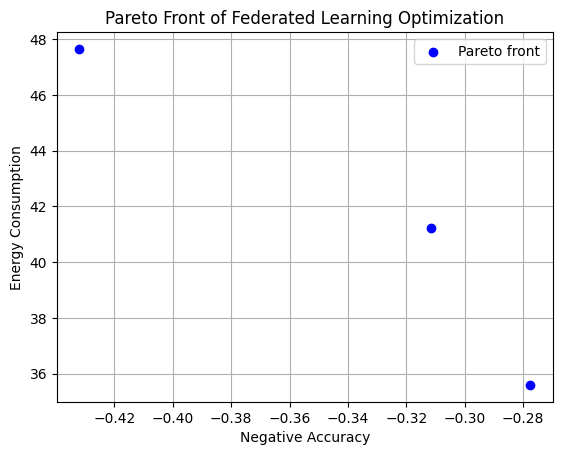

--- Final device accuracies ---
Device 0: Accuracy=0.2809
Device 1: Accuracy=0.2772
Device 2: Accuracy=0.2697
Device 3: Accuracy=0.2772
Device 4: Accuracy=0.2884
Device 5: Accuracy=0.2434
Device 6: Accuracy=0.2697
Device 7: Accuracy=0.2734
Device 8: Accuracy=0.2584
Device 9: Accuracy=0.2360
Device 10: Accuracy=0.2397
Device 11: Accuracy=0.2547
Device 12: Accuracy=0.2772
Device 13: Accuracy=0.2360
Device 14: Accuracy=0.2697
Device 15: Accuracy=0.3333
Device 16: Accuracy=0.3109
Device 17: Accuracy=0.2584
Device 18: Accuracy=0.2846
Device 19: Accuracy=0.2734
Device 20: Accuracy=0.2481
Device 21: Accuracy=0.3158
Device 22: Accuracy=0.2444
Device 23: Accuracy=0.3008
Device 24: Accuracy=0.3083
Device 25: Accuracy=0.3346
Device 26: Accuracy=0.2444
Device 27: Accuracy=0.2895
Device 28: Accuracy=0.3008
Device 29: Accuracy=0.2256


In [37]:
import matplotlib
from matplotlib import pyplot as plt

# Select devices for the first optimal solution
selected_indices = [i for i, participate in enumerate(res.X[0]) if participate]
selected_devices = [devices[i] for i in selected_indices]
print(f"Selected devices for final evaluation: {selected_indices}")

# Aggregate weights from selected devices
if selected_devices:
    final_weights = aggregate_weights(selected_devices)
    global_model.set_weights(final_weights)
else:
    print("Warning: No devices selected in res.X[0]; using current global_model weights")

# Evaluate final global model
_, final_accuracy = global_model.evaluate(x_test_global, y_test_global, verbose=0)
print(f"Final global model accuracy: {final_accuracy:.4f}")

# Plot Pareto front
plt.scatter(res.F[:, 0], res.F[:, 1], c='blue', label='Pareto front')
plt.xlabel('Negative Accuracy')
plt.ylabel('Energy Consumption')
plt.title('Pareto Front of Federated Learning Optimization')
plt.legend()
plt.grid(True)
plt.show()

# Log device accuracies
print("--- Final device accuracies ---")
for device in devices:
    x_test, y_test = device.test_data
    _, acc = global_model.evaluate(x_test, y_test, verbose=0)
    print(f"Device {device.device_id}: Accuracy={acc:.4f}")